In [1]:
!pip install statsmodels
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import zipfile
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

import helper_functions as hlp
import function_model_definition as md
import function_read_data as rdat

print("TF  Version",tf.__version__)

TF  Version 2.4.0


#### Helpfull Links

for best Threshold:
https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

for gradcam averaging:
https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

## Load Data and Results

In [3]:
# Define Version (which splits and models)
version = "10Fold_sigmoid_V2" # one of the following (see ZZ_overview_of_runs.txt for details):
# "10Fold_sigmoid_V0", "10Fold_sigmoid_V1", "10Fold_sigmoid_V2", "10Fold_softmax_V0", "10Fold_softmax_V1", "andrea"

# should csv be saved?
save_file = False

# Define the path
print(os.getcwd())
DIR = "/tf/notebooks/"
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/data/"


/tf/notebooks/brdd/xAI_3d


In [4]:
## 10 Fold
if version.startswith("10Fold"):
    # Define the path + output path:

    DATA_DIR = "/tf/notebooks/brdd/xAI_3d/data/"
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/" + version + "/"

    # load data
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
    X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")

    # define save name
    all_result_name = "all_tab_results_" + version

    # define splits
    which_splits = list(range(0,10)) # 10 Fold

    print(id_tab.shape)
    print(X.shape)

    
## Andrea 6 Split
elif version == "andrea":
    # Define the path + output path:

    IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
    WEIGHT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/andrea_split/"

    # define data paths
    img_path = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
    tab_path = IMG_DIR + 'baseline_data_zurich_prepared.csv'
    split_path = '/tf/notebooks/brdd/xAI_3d/data/andrea_splits.csv'

    # define save name
    all_result_name = "all_tab_results_andrea_split"

    # # define splits
    which_splits = list(range(1,7)) # Andrea


(407, 14)
(407, 128, 128, 28)


In [5]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/brdd/xAI_3d/weights/10Fold_sigmoid_V2/
all_tab_results_10Fold_sigmoid_V2


In [6]:
## define model numbers
if version in ["andrea", "10Fold_sigmoid_V0", "10Fold_softmax_V0", "10Fold_sigmoid_V2", "10Fold_sigmoid_V2f"]:
    model_nrs = list(range(10, 15))
elif version in ["10Fold_softmax_V1", "10Fold_sigmoid_V1"]:
    model_nrs = list(range(10,20))

# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"
    

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True
        

In [7]:
# Define model name
def generate_model_name(which_split, model_nr, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_" + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_nr) + ".h5")

In [8]:
results_list = [] # test dataset results
valid_list = [] # validation datset results

# loop over splits and models
start = time.time()
for which_split in which_splits:
    if check_print:
        print(" ")
        print("---- Start Reading Data of Split " + str(which_split) + " ----")
        print(" ")
    
    # 10 Fold
    if version.startswith("10Fold"):
        (X_train, X_valid, X_test), (y_train, y_valid, y_test) = rdat.split_data(id_tab, X, which_split)
        results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()
    
    # Andrea
    elif version == "andrea":
        (X_train, X_valid, X_test), (y_train, y_valid, y_test), results = rdat.read_and_split_img_data_andrea(
                path_img = img_path, 
                path_tab = tab_path, 
                path_splits = split_path, 
                split = which_split, 
                check_print = check_print)
           
    # add variable with current split
    results["test_split"] = which_split        
    
    # create new df for validation set, to calculate classification threshold 
    # => not cheating when calc on valid
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
    
    if check_print:
        print(" ")
        print("---- Starting Result Calculation of Split " + str(which_split) + " ----")
        print(" ")
        
    y_test_preds = []
    y_valid_preds = []
     
    for model_nr in model_nrs:
        if check_print:
            print("Now calculating model nr. " + str(model_nr))
        
        model_3d.load_weights(generate_model_name(which_split, model_nr, WEIGHT_DIR))
        
        if last_activation == "softmax":
            y_test_preds.append(model_3d.predict(X_test)[:,1].squeeze())
        else:
            y_test_preds.append(model_3d.predict(X_test).squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]
        
        if last_activation == "softmax":
            y_valid_preds.append(model_3d.predict(X_valid)[:,1].squeeze())
        else:
            y_valid_preds.append(model_3d.predict(X_valid).squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]
    
    y_test_preds = np.array(y_test_preds)
    results["y_pred_linear_avg"] = np.mean(y_test_preds, axis = 0)
    results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_test_preds), axis = 0))
    
    y_valid_preds = np.array(y_valid_preds)
    validation_results["y_pred_linear_avg"] = np.mean(y_valid_preds, axis = 0)
    validation_results["y_pred_trafo_avg"] = hlp.sigmoid(np.mean(hlp.inverse_sigmoid(y_valid_preds), axis = 0))
        
    results_list.append(results)
    valid_list.append(validation_results)
        
if check_print:
    end = time.time()
    print(" ")
    print("---- DONE ----")
    print(" ")   
    print("Duration of Execution: " + str(end-start))               
        

 
---- Start Reading Data of Split 0 ----
 
 
---- Starting Result Calculation of Split 0 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 1 ----
 
 
---- Starting Result Calculation of Split 1 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 2 ----
 
 
---- Starting Result Calculation of Split 2 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Split 3 ----
 
 
---- Starting Result Calculation of Split 3 ----
 
Now calculating model nr. 10
Now calculating model nr. 11
Now calculating model nr. 12
Now calculating model nr. 13
Now calculating model nr. 14
 
---- Start Reading Data of Spl

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [9]:
# should threshold be calculated per split or over all?

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.17765816
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6097560975609756
Spezifität:  0.5757575757575757
Sensitivität:  0.75


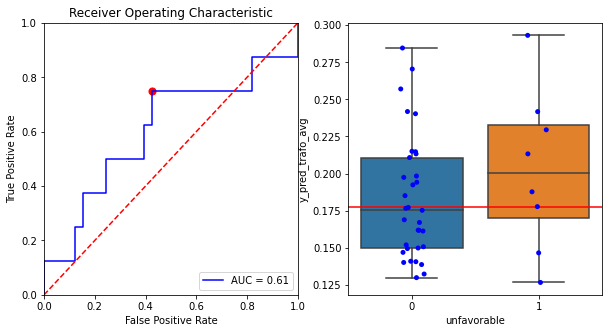

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.20797847
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.7878787878787878
Sensitivität:  0.875


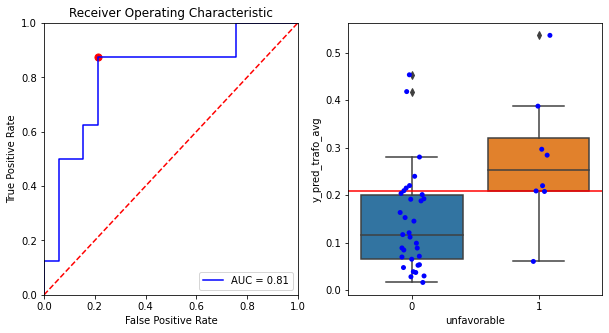

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.3540234
Accuracy to beat: 0.825
Accuracy: 0.875
Spezifität:  0.9696969696969697
Sensitivität:  0.42857142857142855


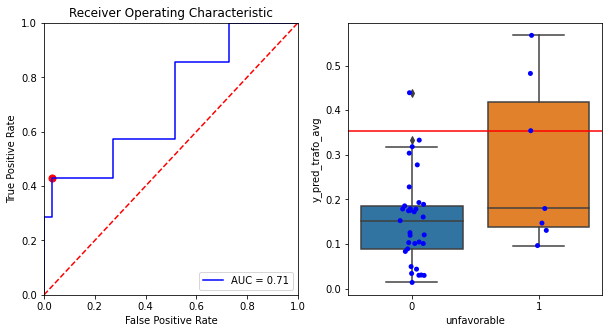

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.14754531
Accuracy to beat: 0.825
Accuracy: 0.75
Spezifität:  0.696969696969697
Sensitivität:  1.0


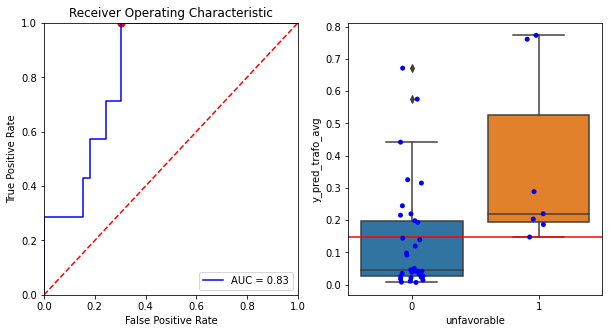

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.17779872
Accuracy to beat: 0.825
Accuracy: 0.85
Spezifität:  0.8484848484848485
Sensitivität:  0.8571428571428571


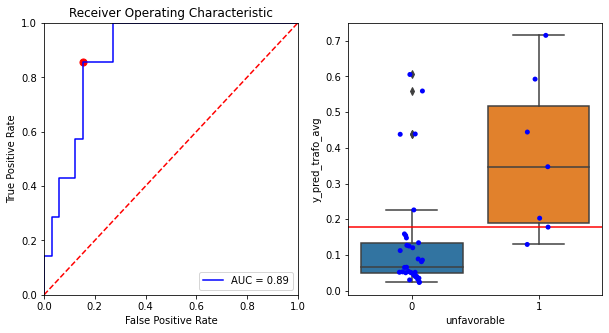

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.3296483
Accuracy to beat: 0.8292682926829268
Accuracy: 0.9024390243902439
Spezifität:  0.9411764705882353
Sensitivität:  0.7142857142857143


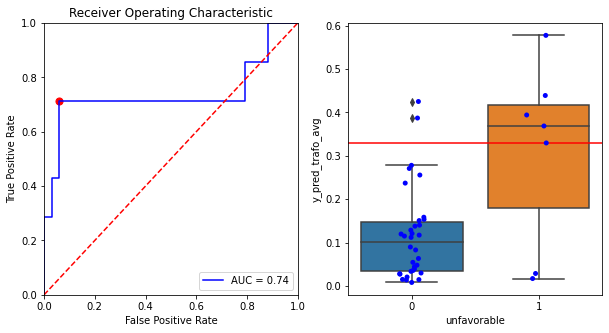

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.17075795
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7560975609756098
Spezifität:  0.7352941176470589
Sensitivität:  0.8571428571428571


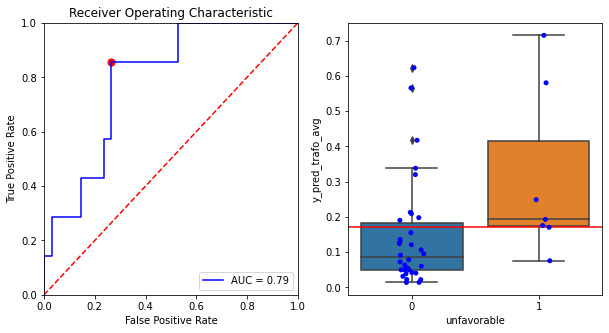

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.32163388
Accuracy to beat: 0.8048780487804879
Accuracy: 0.926829268292683
Spezifität:  0.9393939393939394
Sensitivität:  0.875


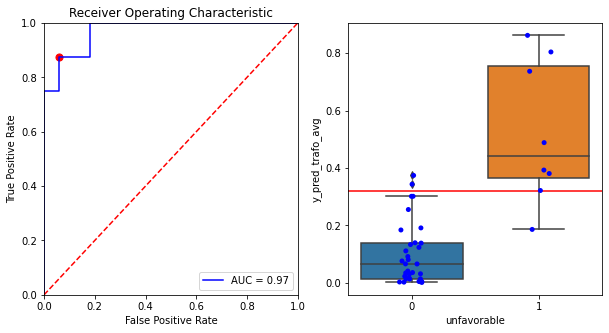

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.22555535
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7560975609756098
Spezifität:  0.7575757575757576
Sensitivität:  0.75


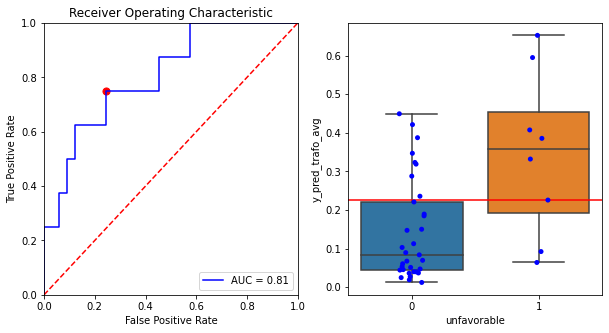

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.16885975
Accuracy to beat: 0.8048780487804879
Accuracy: 0.5365853658536586
Spezifität:  0.48484848484848486
Sensitivität:  0.75


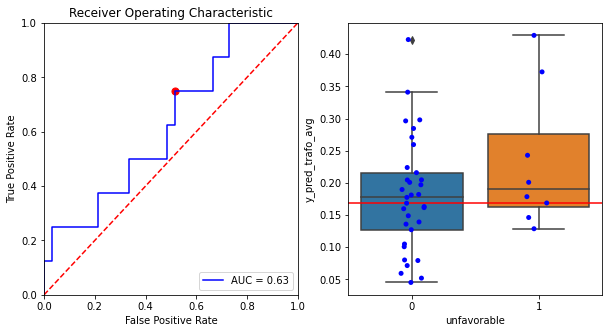

In [10]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [11]:
valid_thresholds

[0.17765816,
 0.20797847,
 0.3540234,
 0.14754531,
 0.17779872,
 0.3296483,
 0.17075795,
 0.32163388,
 0.22555535,
 0.16885975]

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.4634146341463415
Spezifität:  0.4117647058823529
Sensitivität:  0.7142857142857143


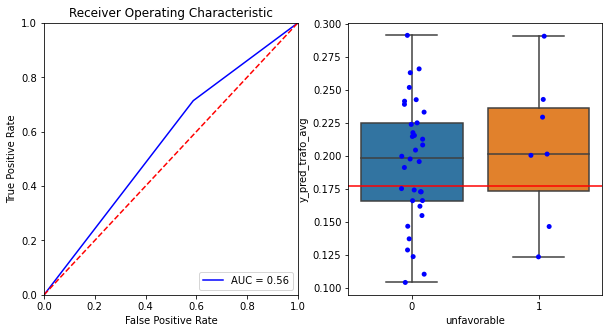

 
---- Split 1 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7317073170731707
Spezifität:  0.7352941176470589
Sensitivität:  0.7142857142857143


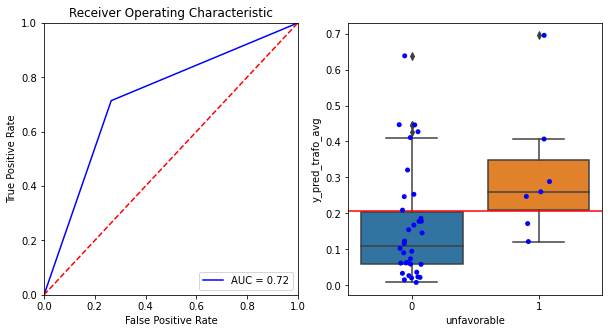

 
---- Split 2 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8536585365853658
Spezifität:  0.9090909090909091
Sensitivität:  0.625


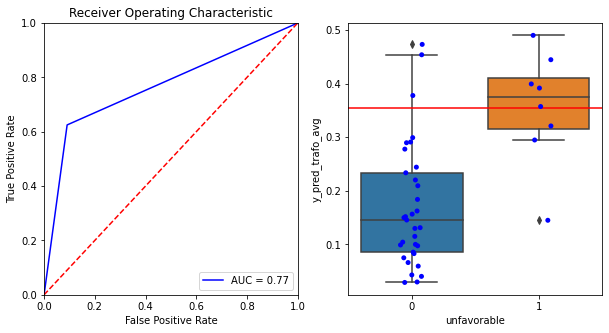

 
---- Split 3 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6341463414634146
Spezifität:  0.6060606060606061
Sensitivität:  0.75


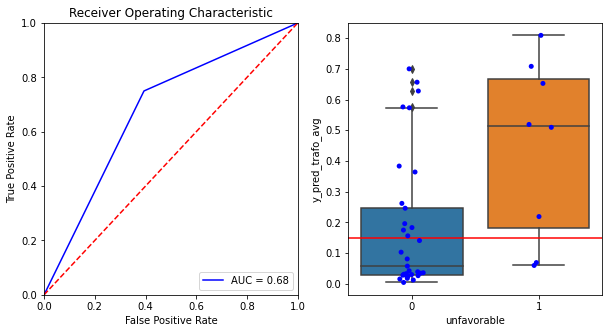

 
---- Split 4 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7073170731707317
Spezifität:  0.7575757575757576
Sensitivität:  0.5


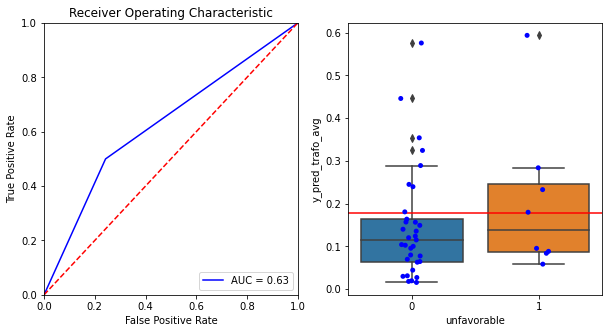

 
---- Split 5 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7317073170731707
Spezifität:  0.8787878787878788
Sensitivität:  0.125


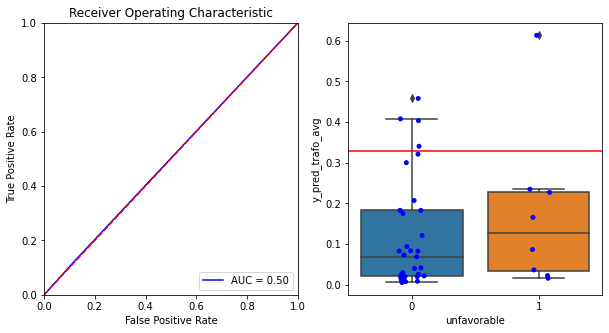

 
---- Split 6 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7317073170731707
Spezifität:  0.7878787878787878
Sensitivität:  0.5


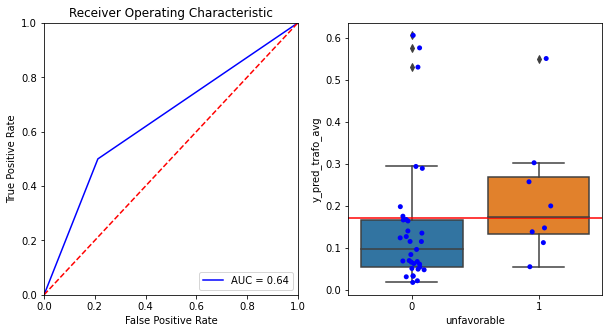

 
---- Split 7 ----
 
Accuracy to beat: 0.825
Accuracy: 0.825
Spezifität:  0.9393939393939394
Sensitivität:  0.2857142857142857


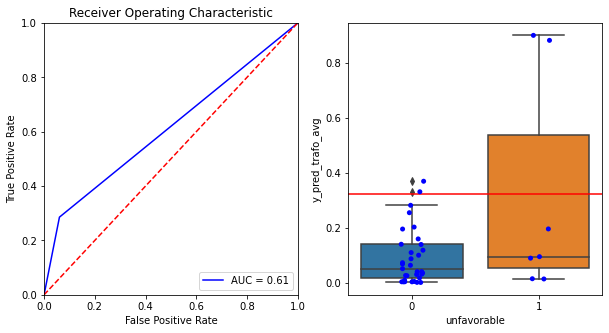

 
---- Split 8 ----
 
Accuracy to beat: 0.825
Accuracy: 0.75
Spezifität:  0.8484848484848485
Sensitivität:  0.2857142857142857


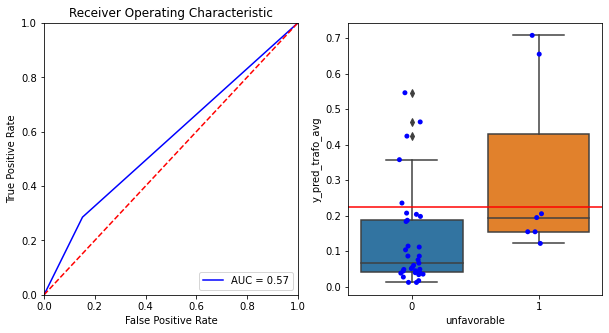

 
---- Split 9 ----
 
Accuracy to beat: 0.825
Accuracy: 0.75
Spezifität:  0.696969696969697
Sensitivität:  1.0


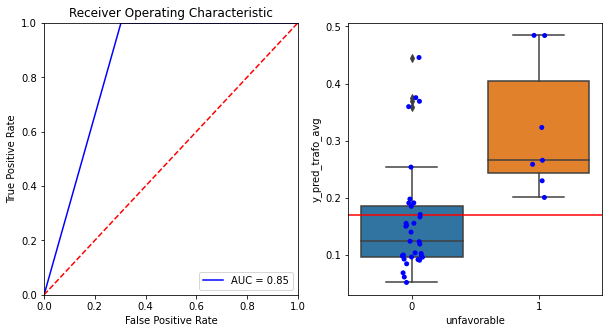

In [12]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [13]:
all_results = pd.concat(results_list)
all_results.shape

(407, 24)

Accuracy to beat: 0.8157248157248157
Accuracy: 0.7174447174447175
Spezifität:  0.7560240963855421
Sensitivität:  0.5466666666666666


<AxesSubplot:xlabel='unfavorable', ylabel='y_pred_trafo_avg'>

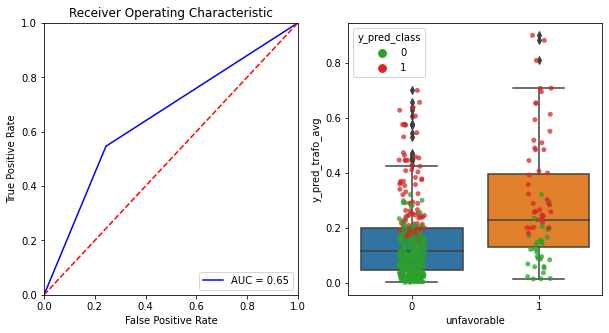

In [14]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

## Calculation of one threshold

threshold:  0.16885975
Accuracy to beat: 0.8157248157248157
Accuracy: 0.6953316953316954
Spezifität:  0.6716867469879518
Sensitivität:  0.8


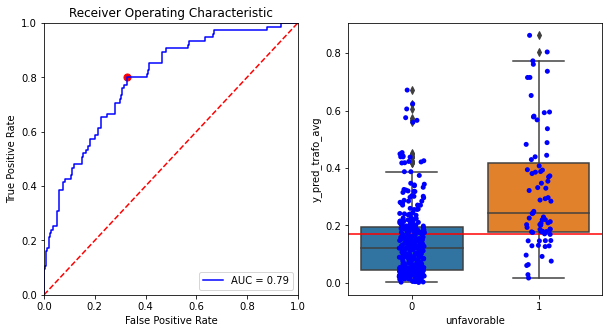

In [15]:
all_valid_results = pd.concat(valid_list)

y_org = all_valid_results["unfavorable"]
y_pred = all_valid_results["y_pred_trafo_avg"]

fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate geometric mean of tpr and fpr to find best threshold
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
valid_threshold = threshold[index]
print("threshold: ", threshold[index])


y_pred_label = (y_pred >= threshold[index]).squeeze()
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[index])
print("Sensitivität: ", tpr[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_valid_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    color = 'blue',
    data = all_valid_results,
    ax = ax2)
ax2.axhline(y = threshold[index], color = "red")

Accuracy to beat:     0.8157
Accuracy:             0.6634
-----------------[95% Conf.]-----------------
AUC of probabilities: 0.7127 [0.6403 0.7747]
NLL :                 0.4394
Threshold:            0.1689
Spezifität:           0.6657 [0.6133 0.7143]
Sensitivität:         0.6533 [0.5405 0.7512]


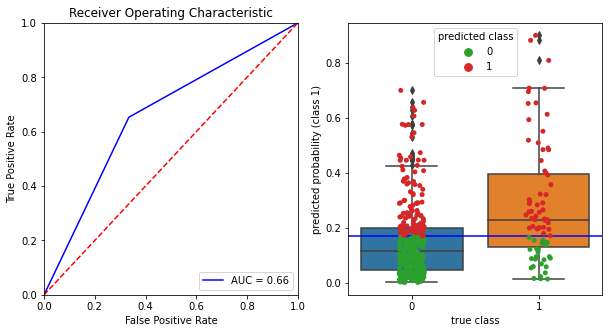

In [16]:
all_results["threshold2"] = valid_threshold
all_results["y_pred_class2"] = (all_results["y_pred_trafo_avg"] >= all_results["threshold2"]).astype(int)

y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class2"]
y_pred_prob = all_results["y_pred_trafo_avg"]

# calculate fpr and tpr for probabilities
fpr_prob, tpr_prob, thresholds_prob = metrics.roc_curve(y_org, y_pred_prob)

# calculate fpr, tpr and thresholds for class
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC confint
AUC0_CI = hlp.compute_auc_ci(y_org, y_pred_prob)

# calculate spez and sens confint
cm = confusion_matrix(y_org, y_pred)
# sens
nobs = sum([cm[1,0],cm[1,1]])
count = sum([cm[1,1]])
sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#spec 
nobs = sum([cm[0,1],cm[0,0]])
count = sum([cm[0,0]])
spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

# Calc Acc
print("Accuracy to beat:     " + str(round(1 - np.mean(y_org), 4)))
print("Accuracy:             " + str(round(np.mean(y_pred == y_org), 4)))
print("-----------------[95% Conf.]-----------------")

print("AUC of probabilities: " + str(round(metrics.auc(fpr_prob, tpr_prob), 4)) + " " +
                                 str(np.around([AUC0_CI[0], AUC0_CI[1]],4)))
print("NLL :                 " + str(round(metrics.log_loss(y_org, y_pred_prob), 4)))

print("Threshold:            " + str(round(valid_threshold, 4)))

print("Spezifität:           " + str(round(1-fpr[1], 4)) + " " +
                                 str(np.around([spec_ci_low, spec_ci_upp],4)))
print("Sensitivität:         " + str(round(tpr[1], 4)) + " " +
                                 str(np.around([sens_ci_low, sens_ci_upp],4)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class2',
    palette=["C2", "C3"],
    data = all_results,
    ax = ax2)
plt.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='predicted probability (class 1)')
ax2.axhline(y = valid_threshold, color = "blue")

In [17]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_11,y_pred_model_12,y_pred_model_13,y_pred_model_14,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,threshold2,y_pred_class2
10,11,15,0.0,0,test,train,train,train,train,val,...,0.166340,0.133086,0.140035,0.183214,0.155862,0.155017,0.177658,0,0.16886,0
24,25,34,0.0,0,test,train,train,train,train,val,...,0.190295,0.212876,0.209401,0.208028,0.204748,0.204633,0.177658,1,0.16886,1
30,31,41,0.0,0,test,train,train,train,train,val,...,0.192484,0.167218,0.188194,0.211139,0.191871,0.191434,0.177658,1,0.16886,1
36,37,48,0.0,0,test,train,train,train,train,val,...,0.184805,0.184465,0.198680,0.206099,0.196110,0.195924,0.177658,1,0.16886,1
79,80,113,3.0,1,test,train,train,train,train,val,...,0.209213,0.272156,0.278404,0.225290,0.244039,0.243040,0.177658,1,0.16886,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,347,489,1.0,0,train,train,train,train,val,train,...,0.127226,0.098873,0.158522,0.061684,0.103514,0.098070,0.168860,0,0.16886,0
359,360,502,6.0,1,train,train,train,train,val,train,...,0.279625,0.166594,0.262335,0.149383,0.205526,0.200450,0.168860,1,0.16886,1
390,391,538,1.0,0,train,train,train,train,val,train,...,0.172833,0.067625,0.173019,0.050200,0.109598,0.098337,0.168860,0,0.16886,0
400,401,552,0.0,0,train,train,train,train,val,train,...,0.133392,0.071319,0.148133,0.074884,0.103639,0.099586,0.168860,0,0.16886,0


## Calculate Model Uncertainty

In [18]:
all_results["y_pred_std"] = all_results[["y_pred_model_1" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0.5, 0, 'true class'), Text(0, 0.5, 'prediction uncertainty')]

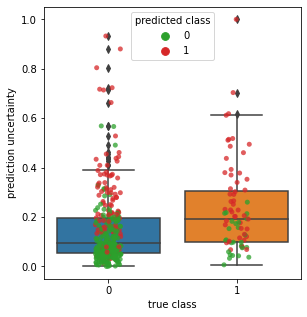

In [19]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class2',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

<AxesSubplot:xlabel='pred_correct', ylabel='y_pred_unc'>

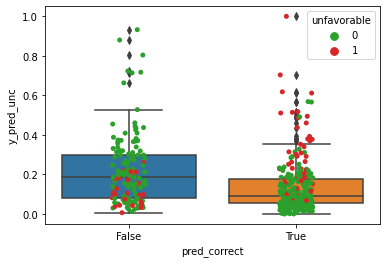

In [20]:
all_results["pred_correct"] = all_results["y_pred_class2"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

<AxesSubplot:xlabel='y_pred_trafo_avg', ylabel='y_pred_unc'>

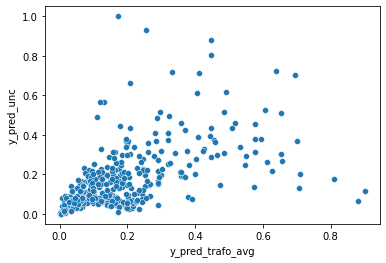

In [21]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
            data = all_results)

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [22]:
all_results = all_results.drop(columns = ["y_pred_class", "threshold"])
all_results = all_results.rename(columns = {"y_pred_class2": "y_pred_class", "threshold2": "threshold"})

In [23]:
if save_file:
    all_results.to_csv(OUTPUT_DIR + all_result_name + ".csv",  index=False) # rename output file!!!!

# Check Splits

Only used for andreas/paper split

In [24]:
if version == "andrea":    
    andrea_splits = pd.read_csv(split_path, 
                                    sep='\,', header = None, engine = 'python', 
                                    usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
    andrea_splits.columns = andrea_splits.iloc[0]
    andrea_splits.drop(index=0, inplace=True)
    andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
    print(andrea_splits[andrea_splits["type"].isin(["test"])].idx.nunique())
    print(sum(andrea_splits["type"].isin(["test"])))

In [25]:
if version == "andrea":
    all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
    all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
    all_dup["p_id"].value_counts().value_counts()

In [26]:
if version == "andrea":
    print("Total duplicate: ", len(all_dup["p_id"].value_counts()))

    print("gleich klassifieziert (%): ", np.mean(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))
    print("gleich klassifieziert (abs): ", np.sum(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))

In [27]:
if version == "andrea":
    sns.histplot(all_dup.groupby("p_id").y_pred_trafo_avg.std())

In [28]:
if version == "andrea":
    all_dup

## Calibration Plot

In [29]:
cal_plot_datas = []
for split in which_splits:
    dat = all_results.loc[all_results["test_split"] == split]
    cal_plot_datas.append(hlp.cal_plot_data_prep(
        dat["y_pred_trafo_avg"].array, dat["unfavorable"].array
    ).select_dtypes(include=np.number))

In [30]:
all_cal_plot_datas = pd.concat(cal_plot_datas)
all_cal_plot_datas["iter"] = all_cal_plot_datas.index
all_cal_plot_datas = all_cal_plot_datas.groupby("iter")[
    ["predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper"]].mean()

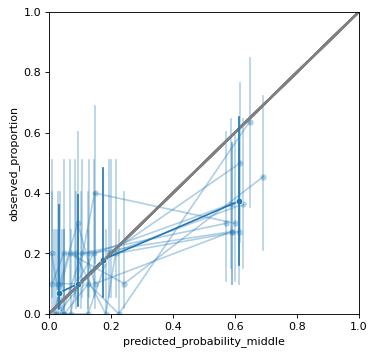

In [31]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

for i in range(len(which_splits)):
    hlp.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
hlp.cal_plot(all_cal_plot_datas, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

## Check Volume index

check if X_test and when selected via p_idx is same => for grad cams, because we have to get volume

In [32]:
with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

In [33]:
index = 0
results.p_id.array[0]

5

In [34]:
np.argwhere(pat == results.p_id.array[index]).squeeze()

array(3)

In [35]:
im1 = X_test[index].astype("float64")
im2 = X_in[np.argwhere(pat == results.p_id.array[index]).squeeze()].astype("float64")
np.allclose(im1, im2)

True

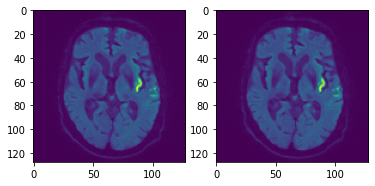

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1[:,:,14])
ax2.imshow(im2[:,:,14])